<a href="https://colab.research.google.com/github/sudhanva-2002/sudhanva-2002.github.io/blob/main/Copy_of_tts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
_, card = !nvidia-smi --query-gpu=gpu_name --format='csv'
print(card)


Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os
from os.path import exists
if not exists('/content/drive'):
    drive.mount('drive', force_remount=True)

In [ ]:
import os
%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  !git clone https://github.com/justinjohn0306/TTS-TT2.git
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update
%cd /content/TTS-TT2/
!pip install matplotlib numpy inflect scipy Unidecode pillow
!pip install git+https://github.com/wkentaro/gdown.git
import gdown
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh
tt2_pretrained = "https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
if not os.path.isfile("/content/TTS-TT2/pretrained_model"):
  gdown.download(tt2_pretrained, "/content/TTS-TT2/pretrained_model", quiet=False)
if not os.path.isfile("/content/TTS-TT2/text/merged.dict.txt"):
  # !curl https://cdn.discordapp.com/attachments/820353681567907901/865742324084244480/tacotron2-cmudict-patch.zip -o /content/tacotron2-cmudict-patch.zip
  gdown.download("https://drive.google.com/uc?id=1xgtiHABttD4MTds4KUPjghXfLqvzln2_", "/content/tacotron2-cmudict-patch.zip", quiet=False)
  !unzip -o /content/tacotron2-cmudict-patch.zip -d /content/TTS-TT2/text/
  !mv /content/TTS-TT2/text/merged.dict.txt /content/TTS-TT2/

latest_downloaded = None

/content
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 76 (delta 0), reused 1 (delta 0), pack-reused 72
Unpacking objects: 100% (76/76), 1.81 MiB | 10.55 MiB/s, done.
/content/TTS-TT2
/content/TTS-TT2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-nmf7zhz4
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-nmf7zhz4
  Resolved https://github.com/wkentaro/gdown.git to commit 5c7507f02718048899b85d4010a6ed93316cbf27
  Running command git submodule update --init --recursive -q
  Installing build dependencies ...

Downloading...
From (original): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
From (redirected): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA&confirm=t&uuid=198c4920-dc19-4ede-ba1e-4b377a286bd1
To: /content/TTS-TT2/pretrained_model
100%|██████████| 113M/113M [00:00<00:00, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xgtiHABttD4MTds4KUPjghXfLqvzln2_
To: /content/tacotron2-cmudict-patch.zip
100%|██████████| 893k/893k [00:00<00:00, 62.3MB/s]

Archive:  /content/tacotron2-cmudict-patch.zip
  inflating: /content/TTS-TT2/text/cleaners.py  
  inflating: /content/TTS-TT2/text/cmudict.py  
  inflating: /content/TTS-TT2/text/LICENSE  
  inflating: /content/TTS-TT2/text/README  
  inflating: /content/TTS-TT2/text/__init__.py  
  inflating: /content/TTS-TT2/text/merged.dict.txt  


In [ ]:
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
from tqdm.notebook import tqdm
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")


    torch.cuda.set_device(rank % torch.cuda.device_count())

    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):

    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    if True:
        print("Saving model and optimizer state at iteration {} to {}".format(
            iteration, filepath))
        try:
            torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
        except KeyboardInterrupt:
            print("interrupt received while saving, waiting for save to complete.")
            torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
        print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):

    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)


    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("/content/TTS-TT2/pretrained_model")
      %cd /dev/null
      !/content/TTS-TT2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      %cd /content/TTS-TT2
      model = warm_start_model("/content/TTS-TT2/pretrained_model", model, hparams.ignore_layers)


    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter()
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)


            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs: # not sure if the latter is necessary
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path + "_epoch_%s" % (epoch+1))
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"

hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 100
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' #save Checkpoints
log_directory = '/content/TTS-TT2/logs'
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}


%cd /content/TTS-TT2

data_path = 'wavs'
!mkdir {data_path}

sed: can't read filelists/clipper_train_filelist.txt: No such file or directory
sed: can't read filelists/clipper_val_filelist.txt: No such file or directory
/content/TTS-TT2
mkdir: cannot create directory ‘wavs’: File exists


In [ ]:
audio_processing = True
drive_path = "/content/drive/MyDrive/wavs/10audio.zip"

from google.colab import files
import zipfile
import os
import wave
import shutil
import datetime

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    ffmpeg -y -i /content/tempwav/srtmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

%cd /content/TTS-TT2/wavs

drive_path = drive_path.strip()

if drive_path:
  if os.path.exists(drive_path):
    print(f"\n\033[34m\033[1mAudio imported from Drive.\n\033[90m")
    if zipfile.is_zipfile(drive_path):
      !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs

    else:
      fp = drive_path + "/."
      !cp -a "$fp" "/content/TTS-TT2/wavs"
  else:
    print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
    print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
    uploaded = files.upload()
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()

  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt
if audio_processing:
  print(f"\n\033[37mMetadata removal and audio verification...")
  !mkdir /content/tempwav
  !bash /content/audios.sh

totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration

        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")



print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/wavs

Audio imported from Drive.

rm: cannot remove '/content/TTS-TT2/wavs/list.txt': No such file or directory

Metadata removal and audio verification...

10 processed audios. total duration: 0:01:07


All set, please proceed.


In [ ]:

drive_path = "/content/drive/MyDrive/wavs/10audio.zip"

from google.colab import files
import zipfile
import os
import wave
import shutil
import datetime

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    sox /content/tempwav/srtmp.wav  -c 1 /content/tempwav/ntmp.wav norm -0.1
    ffmpeg -y -i /content/tempwav/ntmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

%cd /content/TTS-TT2/wavs

drive_path = drive_path.strip()

if drive_path:
  if os.path.exists(drive_path):
    print(f"\n\033[34m\033[1mAudio imported from Drive.\n\033[90m")
    if zipfile.is_zipfile(drive_path):
      !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs

    else:
      fp = drive_path + "/."
      !cp -a "$fp" "/content/TTS-TT2/wavs"
  else:
    print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
    print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
    uploaded = files.upload()
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()

  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt

print(f"\n\033[37mNormalization, metadata removal and audio verification...")
!mkdir /content/tempwav
!bash /content/audios.sh

totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration

        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")


print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/wavs

Audio imported from Drive.

rm: cannot remove '/content/TTS-TT2/wavs/list.txt': No such file or directory

Normalization, metadata removal and audio verification...
mkdir: cannot create directory ‘/content/tempwav’: File exists

10 processed audios. total duration: 0:01:07


All set, please proceed.


In [ ]:
%cd /content/TTS-TT2/filelists/
!rm /content/TTS-TT2/filelists/list.txt


listfn, length = files.upload().popitem()

if listfn != "list.txt":
  !mv "$listfn" list.txt
%cd /content/TTS-TT2/
print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/filelists
rm: cannot remove '/content/TTS-TT2/filelists/list.txt': No such file or directory


Saving list12.txt to list12.txt
/content/TTS-TT2

All set, please proceed.


In [ ]:
model_filename = 'test'


Training_file = "/content/TTS-TT2/filelists/list.txt"
hparams.training_files = Training_file
hparams.validation_files = Training_file


hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1


hparams.decay_start = 15000

hparams.A_ = 3e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5


generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000


hparams.batch_size =  6
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
use_cmudict = True


hparams.epochseg =  5

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark


output_directory = '/content/drive/MyDrive/colab/outdir'
log_directory = '/content/TTS-TT2/logs'
log_directory2 = '/content/drive/My Drive/colab/logs'
checkpoint_path = output_directory+(r'/')+model_filename




hparams.text_cleaners=["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict is True else [])




In [ ]:
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
%cd /content/TTS-TT2/
import text

/content/TTS-TT2


In [ ]:
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

check_dataset(hparams)

Checking Training Files
/content/TTS-TT2/wavs/4.npy|produced the block books, which were the immediate predecessors of the true printed book 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/7.npy|the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about fourteen fifty-five 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/8.npy|has never been surpassed.|has never been surpassed. 
has multiple '|', this may not be an error.
/content/TTS-TT2/wavs/10.npy|Now, as all books not primarily intended as picture-books consist principally of types composed to form letterpress 
[info] has no ending punctuation.
Checking Validation Files
/content/TTS-TT2/wavs/4.npy|produced the block books, which were the immediate predecessors of the true printed book 
[info] has no ending punctuation.
/content/TTS-TT2/wavs/7.npy|the earliest book printed with movable types, the Gutenberg, or "forty-two line Bible" of about fourteen fifty-five 
[info] has no end

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Loading checkpoint '/content/drive/MyDrive/colab/outdir/test'
Loaded checkpoint '/content/drive/MyDrive/colab/outdir/test' from iteration 40


  0%|          | 0/59 [00:00<?, ?it/s]


Starting Epoch: 41 Iteration: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41 Validation loss 42:  0.192998  Time: 0.1m LR: 0.000300


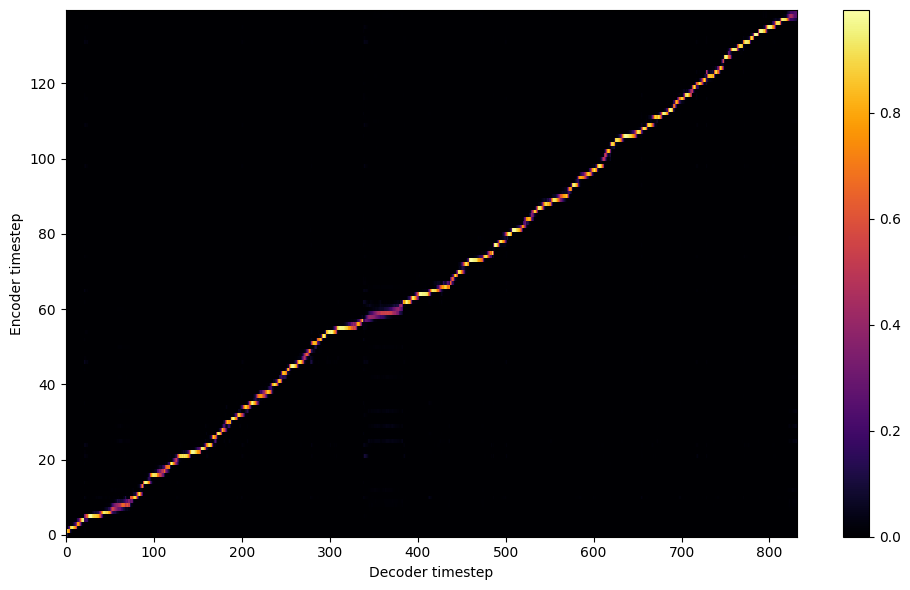

Saving model and optimizer state at iteration 42 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 42 Iteration: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42 Validation loss 43:  0.192059  Time: 0.1m LR: 0.000300


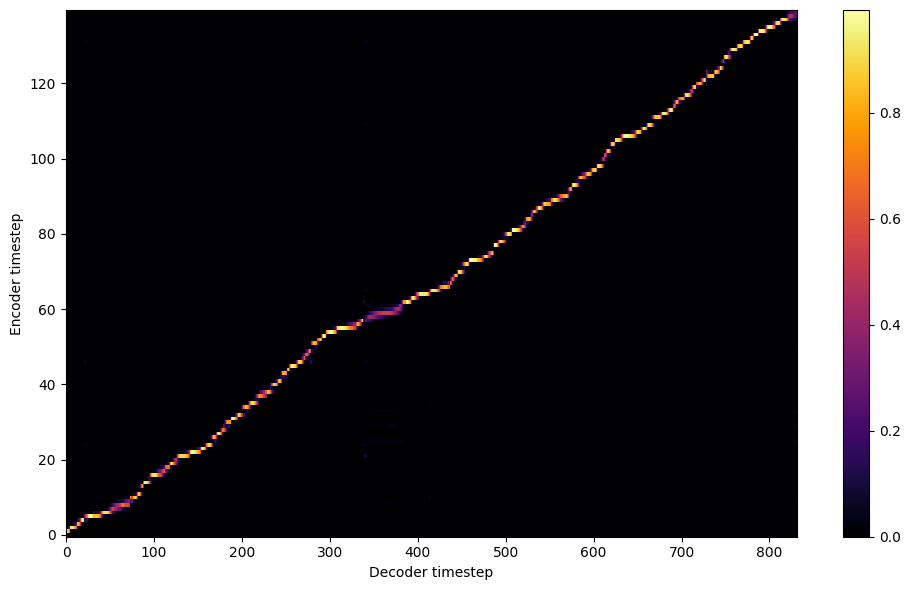

Saving model and optimizer state at iteration 43 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 43 Iteration: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43 Validation loss 44:  0.188855  Time: 0.1m LR: 0.000300


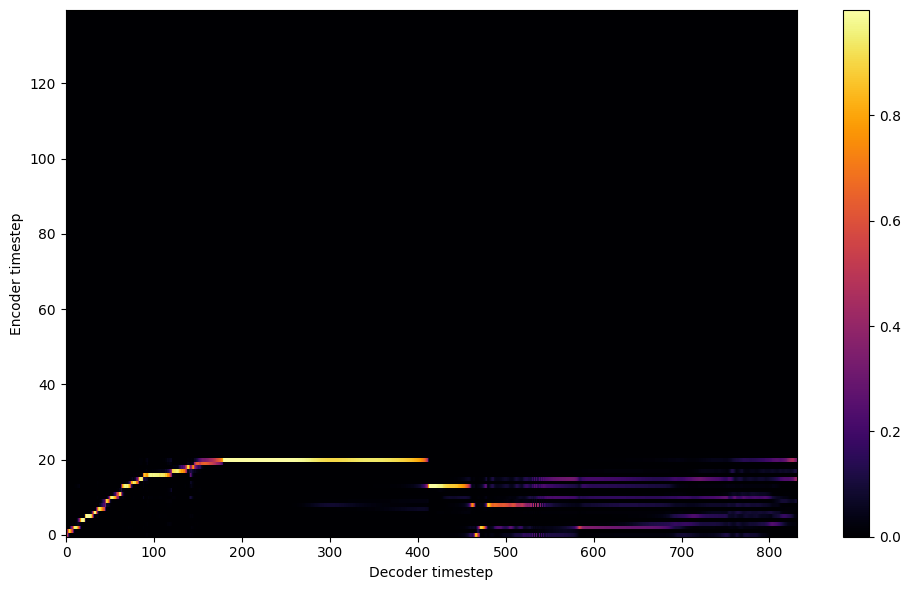

Saving model and optimizer state at iteration 44 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 44 Iteration: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44 Validation loss 45:  0.188778  Time: 0.1m LR: 0.000300


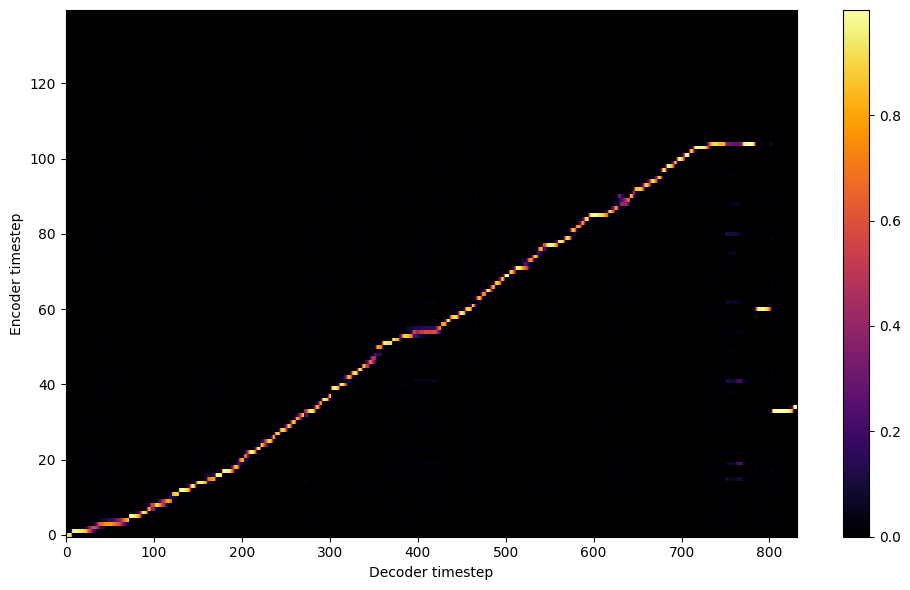

Saving model and optimizer state at iteration 45 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 45 Iteration: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45 Validation loss 46:  0.202096  Time: 0.1m LR: 0.000300


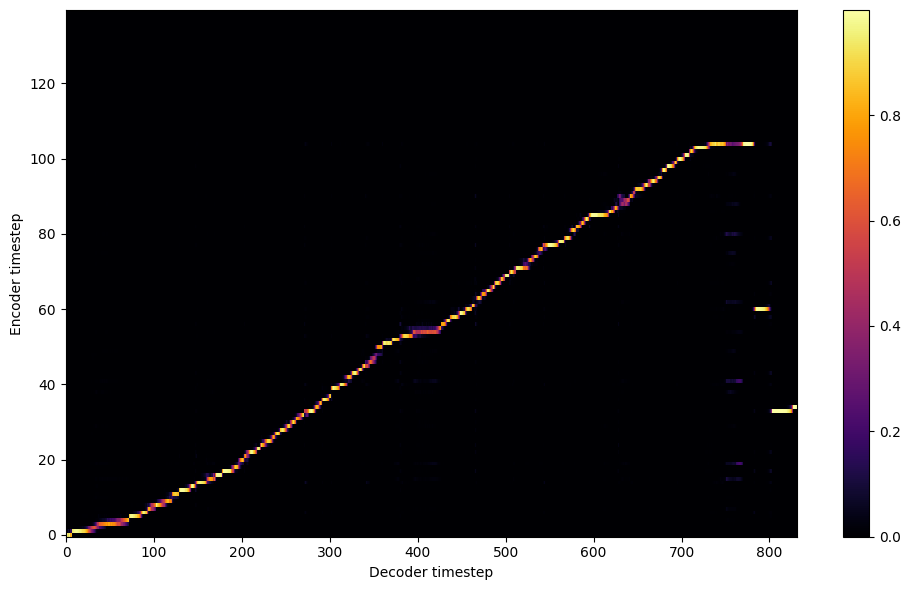

Saving model and optimizer state at iteration 46 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 46 Iteration: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46 Validation loss 47:  0.220388  Time: 0.1m LR: 0.000300


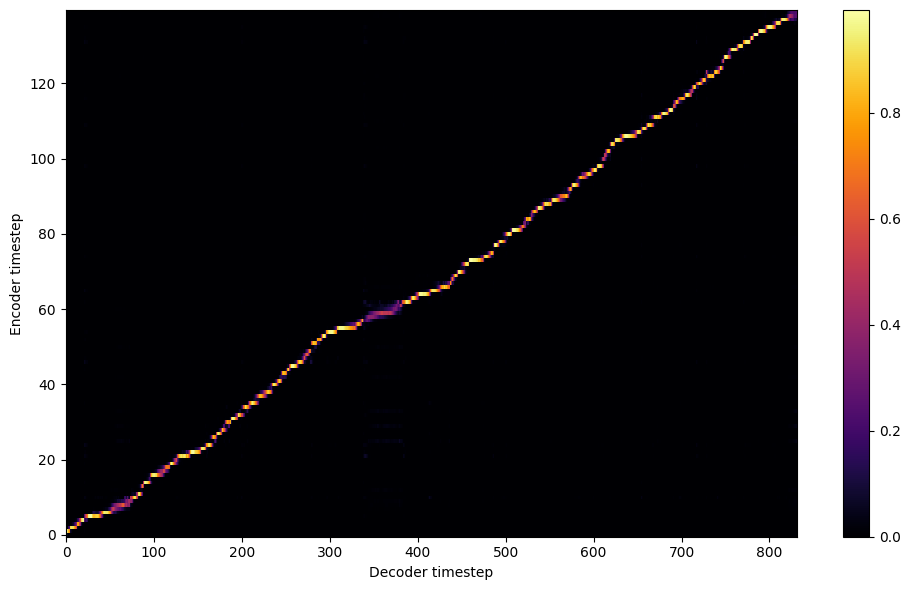

Saving model and optimizer state at iteration 47 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 47 Iteration: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47 Validation loss 48:  0.208421  Time: 0.1m LR: 0.000300


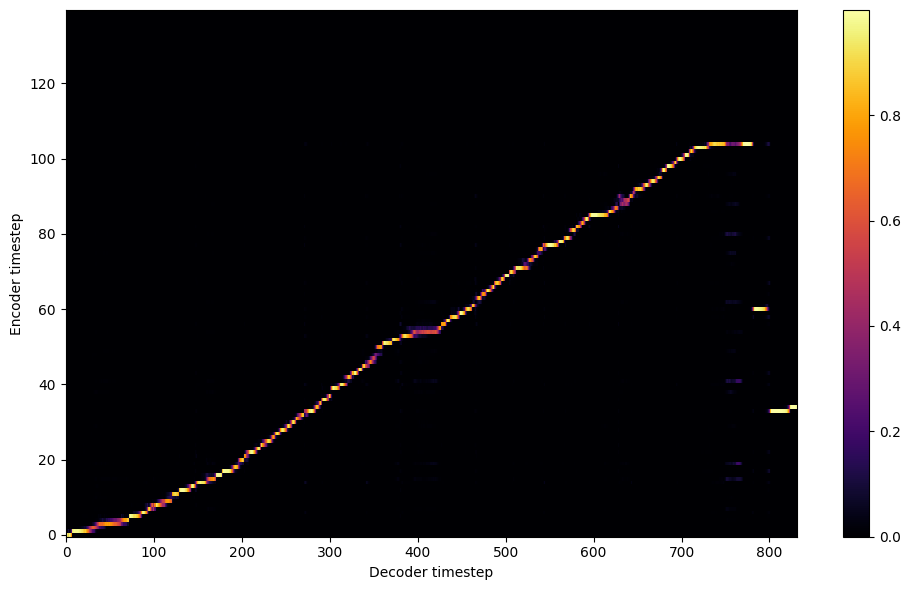

Saving model and optimizer state at iteration 48 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 48 Iteration: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48 Validation loss 49:  0.196012  Time: 0.1m LR: 0.000300


Exception ignored in: <function _xla_gc_callback at 0x7fe421dce7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


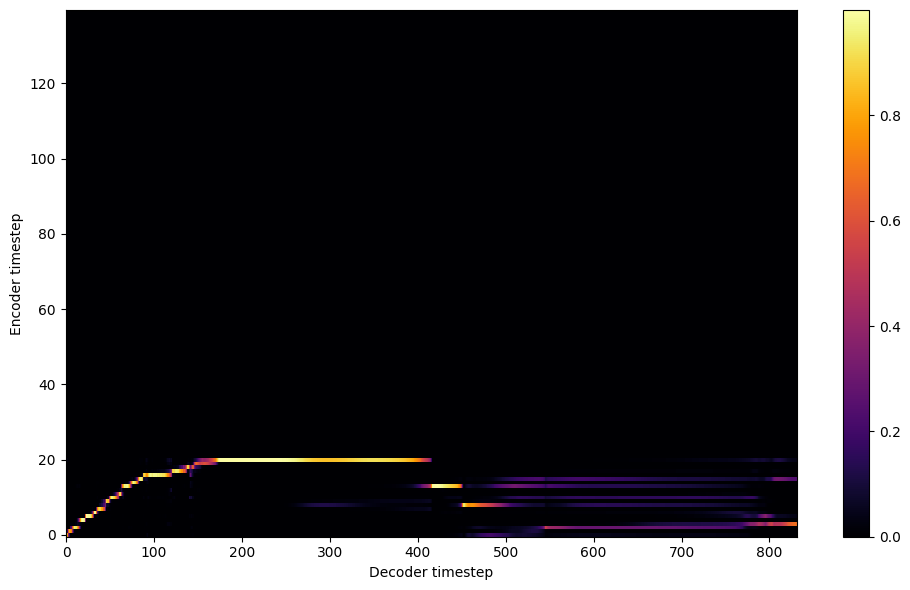

Saving model and optimizer state at iteration 49 to /content/drive/MyDrive/colab/outdir/test
Model Saved

Starting Epoch: 49 Iteration: 49


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:

import time
save_interval =  1

backup_interval =  -1


print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2,
      save_interval, backup_interval)

In [ ]:
!pip install -q torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 torchtext==0.14.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -U


In [1]:


!pip install -q torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 torchtext==0.14.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -U

import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)



tacotron_id = "1-cCgYR-khp5elZnZntEusHAAZFYFaf9h"

hifigan_id = "universal"

if tacotron_id != "":
    TACOTRON2_ID = tacotron_id
else:
    raise Exception("No ID provided.")

if hifigan_id in {"", "universal"}:
    HIFIGAN_ID = "universal"
    print("Using universal Hifi-Gan model.")
else:
    HIFIGAN_ID = hifigan_id

try:
    initialized
except NameError:
    print("Setting up, please wait.\n")
    !pip install tqdm -q
    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        import os
        from os.path import exists, join, basename, splitext
        !pip install resampy
        !pip install git+https://github.com/wkentaro/gdown.git
        git_repo_url = 'https://github.com/justinjohn0306/TTS-TT2.git'
        project_name = splitext(basename(git_repo_url))[0]
        if not exists(project_name):

            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/justinjohn0306/hifi-gan
            !pip install -q unidecode
        pbar.update(1)
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import mel_spectrogram, MAX_WAV_VALUE
        from models import Generator
        from denoiser import Denoiser
        import resampy
        import scipy.signal

        pbar.update(1)
        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='lower',
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        !wget 'https://github.com/justinjohn0306/tacotron2/releases/download/assets/merged.dict.txt'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1)
        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID, conf_name):

            hifigan_pretrained_model = 'hifimodel_' + conf_name


            if MODEL_ID == 1:
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/Superres_Twilight_33000" -O $hifigan_pretrained_model
            elif MODEL_ID == "universal":
              !wget "https://github.com/justinjohn0306/tacotron2/releases/download/assets/g_02500000" -O $hifigan_pretrained_model
            else:
              gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", conf_name + ".json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cuda"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            denoiser = Denoiser(hifigan, mode="normal")
            return hifigan, h, denoiser


        hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")

        hifigan_sr, h2, denoiser_sr = get_hifigan(1, "config_32k")
        pbar.update(1)

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):

            tacotron2_pretrained_model = 'MLPTTS'
            gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")

            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000
            hparams.gate_threshold = 0.25
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.cuda().eval().half()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";"
                else: i = ARPA(i)
                with torch.no_grad():
                    sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    audio_denoised = denoiser(audio.view(1, -1), strength=35)[:, 0]


                    audio_denoised = audio_denoised.cpu().numpy().reshape(-1)

                    normalize = (MAX_WAV_VALUE / np.max(np.abs(audio_denoised))) ** 0.9
                    audio_denoised = audio_denoised * normalize
                    wave = resampy.resample(
                        audio_denoised,
                        h.sampling_rate,
                        h2.sampling_rate,
                        filter="sinc_window",
                        window=scipy.signal.windows.hann,
                        num_zeros=8,
                    )
                    wave_out = wave.astype(np.int16)

                    # HiFi-GAN super-resolution
                    wave = wave / MAX_WAV_VALUE
                    wave = torch.FloatTensor(wave).to(torch.device("cuda"))
                    new_mel = mel_spectrogram(
                        wave.unsqueeze(0),
                        h2.n_fft,
                        h2.num_mels,
                        h2.sampling_rate,
                        h2.hop_size,
                        h2.win_size,
                        h2.fmin,
                        h2.fmax,
                    )
                    y_g_hat2 = hifigan_sr(new_mel)
                    audio2 = y_g_hat2.squeeze()
                    audio2 = audio2 * MAX_WAV_VALUE
                    audio2_denoised = denoiser(audio2.view(1, -1), strength=35)[:, 0]


                    audio2_denoised = audio2_denoised.cpu().numpy().reshape(-1)
                    b = scipy.signal.firwin(
                        101, cutoff=10500, fs=h2.sampling_rate, pass_zero=False
                    )
                    y = scipy.signal.lfilter(b, [1.0], audio2_denoised)
                    y *= superres_strength
                    y_out = y.astype(np.int16)
                    y_padded = np.zeros(wave_out.shape)
                    y_padded[: y_out.shape[0]] = y_out
                    sr_mix = wave_out + y_padded
                    sr_mix = sr_mix / normalize

                    print("")
                    ipd.display(ipd.Audio(sr_mix.astype(np.int16), rate=h2.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initialized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h, denoiser = get_hifigan(HIFIGAN_ID, "config_v1")
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False

show_graphs = False
max_duration = 20
model.decoder.max_decoder_steps = max_duration * 80
stop_threshold = 0.5
model.decoder.gate_threshold = stop_threshold
superres_strength = 10


print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\nsuperres_strength: {superres_strength}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, not pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break

Current Config:
pronounciation_dictionary: False
show_graphs: False
max_duration (in seconds): 20
stop_threshold: 0.5
superres_strength: 10


Enter/Paste your text.
--------------------------------------------------
hiii



/usr/local/lib/python3.10/dist-packages/torch/functional.py:632: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


--------------------------------------------------
Stopping...


In [ ]:
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, not pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break

Enter/Paste your text.
--------------------------------------------------
Stopping...
